# Table of Contents

### **0. Importing Libraries & Dataset**
### **1. Data Cleaning & Preprocessing**
 #### *1.1. Checking, and Converting Dtypes*
 #### *1.2 Filtering Dataset*
 #### *1.3 Deleting Duplicates*
 #### *1.4 Identifying, and Handling Missing Data*
 #### *1.5. Exploratory Data Analysis (EDA) & Dealing with Outliers*
 #### *1.6. Dropping Irrelevant Variables*
 #### *1.7. Feature Creation*
 ##### 1.7.1. Creating Latitude and Longitude
 ##### 1.7.2. Creating Volume, Total kWh Consumption
### **2. Splitting Labelled and Unlabelled Data**
### **3. EDA & Preprocessing on Labelled Dataset**
 #### *3.1. Check for Class Imbalance in Target Variable* 
 #### *3.2. Removing Infrequent Classes & Merging A Classes*
 #### *3.3. Check the Correlation Matrix*
 #### *3.4. Exporting CSV for QGIS*
### **4. Splitting in Train, Validation & Test Sets**
 #### *4.1. Encoding Target Labels (Energy Labels) + Scaling data*
### **5. Classifiers**
 #### *5.1. Baseline Random Forest*
  ##### 5.1.1. Evaluation
 #### *5.2. Baseline XGBoost*
  ##### 5.2.1. Evaluation
 #### *5.3. Baseline TabNet*
  ##### 5.3.1. Evaluation


# 0. Importing Libraries & Dataset

In [1]:
import pandas as pd
import geopandas as gpd
import shapely.geometry as sg
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.wkt import loads
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, balanced_accuracy_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score
import torch
import torch.optim
import optuna
from optuna import Trial, visualization
from sklearn.semi_supervised import LabelPropagation, SelfTrainingClassifier
import warnings
warnings.filterwarnings('ignore') 

In [2]:
df_raw = pd.read_csv('pand-energie-cbs-brabant.csv')

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152018 entries, 0 to 2152017
Data columns (total 55 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   identificatie               int64  
 1   bouwjaar                    int64  
 2   area                        object 
 3   kas_warenhuis               bool   
 4   geometry                    object 
 5   hoogte                      object 
 6   gasm3_2022                  float64
 7   gas_aansluitingen_2022      float64
 8   group_id_2022               object 
 9   pandcount_2022              float64
 10  kwh_aansluitingen_2022      float64
 11  kwh_2022                    float64
 12  kwh_leveringsrichting_2022  float64
 13  ean_code_count              float64
 14  grondbeslag_m2_p6           object 
 15  volume_m3_p6                object 
 16  gasm3_grondbeslag_p6        object 
 17  gasm3_volume_p6             object 
 18  gasm3_totaal_p6             object 
 19  energieklasse_score  

In [4]:
# Deleting unnecessary CBS variables (not needed for this research, not originating from DEGO)
df = df_raw.drop(df_raw.iloc[:, 23:55],axis = 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152018 entries, 0 to 2152017
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   identificatie               int64  
 1   bouwjaar                    int64  
 2   area                        object 
 3   kas_warenhuis               bool   
 4   geometry                    object 
 5   hoogte                      object 
 6   gasm3_2022                  float64
 7   gas_aansluitingen_2022      float64
 8   group_id_2022               object 
 9   pandcount_2022              float64
 10  kwh_aansluitingen_2022      float64
 11  kwh_2022                    float64
 12  kwh_leveringsrichting_2022  float64
 13  ean_code_count              float64
 14  grondbeslag_m2_p6           object 
 15  volume_m3_p6                object 
 16  gasm3_grondbeslag_p6        object 
 17  gasm3_volume_p6             object 
 18  gasm3_totaal_p6             object 
 19  energieklasse_score  

In [6]:
# removing unnecessary/reduntant variables
df = df.drop(['energieklasse_score','ean_code_count'], axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152018 entries, 0 to 2152017
Data columns (total 21 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   identificatie               int64  
 1   bouwjaar                    int64  
 2   area                        object 
 3   kas_warenhuis               bool   
 4   geometry                    object 
 5   hoogte                      object 
 6   gasm3_2022                  float64
 7   gas_aansluitingen_2022      float64
 8   group_id_2022               object 
 9   pandcount_2022              float64
 10  kwh_aansluitingen_2022      float64
 11  kwh_2022                    float64
 12  kwh_leveringsrichting_2022  float64
 13  grondbeslag_m2_p6           object 
 14  volume_m3_p6                object 
 15  gasm3_grondbeslag_p6        object 
 16  gasm3_volume_p6             object 
 17  gasm3_totaal_p6             object 
 18  energie_label               float64
 19  woonfunctie_score    

In [8]:
pd.set_option("display.max_columns", None)
df.head(5)

,identificatie,bouwjaar,area,kas_warenhuis,geometry,hoogte,gasm3_2022,gas_aansluitingen_2022,group_id_2022,pandcount_2022,kwh_aansluitingen_2022,kwh_2022,kwh_leveringsrichting_2022,grondbeslag_m2_p6,volume_m3_p6,gasm3_grondbeslag_p6,gasm3_volume_p6,gasm3_totaal_p6,energie_label,woonfunctie_score,pc6
0,856100000356365,1850,"277,73",False,"POLYGON ((621077.3184342801 6736812.555291426,...","7,87",5495.0,20.0,5406TH,26.0,24.0,14654.0,63.0,"9793,38","49363,05","11,22","2,23",109898,NaN,100.0,5406TH
1,856100000355469,1971,"55,4",False,"POLYGON ((627505.437494008 6739077.3316790685,...","6,94",1244.0,16.0,5403TD,18.0,16.0,2718.0,38.0,"914,64","6338,81","21,76","3,14","19899,04",6.0,100.0,5403TD
2,856100000355579,1990,"47,48",False,"POLYGON ((625364.0460081735 6737294.550473032,...","7,19",732.0,26.0,5404LW,28.0,26.0,1769.0,4.0,"1252,11","8058,94","15,21","2,36","19041,1",7.0,100.0,5404LW
3,856100000355657,2004,"9,99",False,POLYGON ((626396.3500566207 6736479.7152666515...,"2,71",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,856100000355676,1971,"155,38",False,"POLYGON ((623679.4202361606 6734226.555212357,...","3,3",4530.0,40.0,5406PX-5406TB,54.0,44.0,10472.0,73.0,"15596,32","95011,44","11,62","1,91","181216,05",NaN,100.0,5406TB


In [9]:
df.shape

(2152018, 21)

In [10]:
# Renaming column names
df.rename(columns = {'bouwjaar': 'Construction Year', 'area':'Area', 'hoogte': 'Height', 'kwh_leveringsrichting_2022': 'Net Metering', 
                                 'gasm3_totaal_p6' : 'gasm3_total_p6', 'energie_label': 'Energy Label'}, 
                      inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152018 entries, 0 to 2152017
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   identificatie           int64  
 1   Construction Year       int64  
 2   Area                    object 
 3   kas_warenhuis           bool   
 4   geometry                object 
 5   Height                  object 
 6   gasm3_2022              float64
 7   gas_aansluitingen_2022  float64
 8   group_id_2022           object 
 9   pandcount_2022          float64
 10  kwh_aansluitingen_2022  float64
 11  kwh_2022                float64
 12  Net Metering            float64
 13  ean_code_count          float64
 14  grondbeslag_m2_p6       object 
 15  volume_m3_p6            object 
 16  gasm3_grondbeslag_p6    object 
 17  gasm3_volume_p6         object 
 18  gasm3_total_p6          object 
 19  Energy Label            float64
 20  woonfunctie_score       float64
 21  pc6                     object 

# 1. Data Cleaning & Preprocessing

#### 1.1 checking dtypes

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152018 entries, 0 to 2152017
Data columns (total 21 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   identificatie           int64  
 1   Construction Year       int64  
 2   Area                    object 
 3   kas_warenhuis           bool   
 4   geometry                object 
 5   Height                  object 
 6   gasm3_2022              float64
 7   gas_aansluitingen_2022  float64
 8   group_id_2022           object 
 9   pandcount_2022          float64
 10  kwh_aansluitingen_2022  float64
 11  kwh_2022                float64
 12  Net Metering            float64
 13  grondbeslag_m2_p6       object 
 14  volume_m3_p6            object 
 15  gasm3_grondbeslag_p6    object 
 16  gasm3_volume_p6         object 
 17  gasm3_total_p6          object 
 18  Energy Label            float64
 19  woonfunctie_score       float64
 20  pc6                     object 
dtypes: bool(1), float64(8), int64(2

In [14]:
# Replacing the comma's with points to prepare to convert variables to floats
variables = ['Area', 'Height', 'grondbeslag_m2_p6', 'volume_m3_p6', 'gasm3_grondbeslag_p6', 'gasm3_volume_p6', 'gasm3_total_p6']
for i in variables:
    df[i] = df[i].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
    df[i] = df[i].astype('float')

#### 1.2 Filtering dataset to include only houses

In [15]:
# Only keeping buildings with solely residential function (office-buildings, hospitals, companies, etc)
df_residential = df[df['woonfunctie_score'] == 100]
print('DataFrame shape after filtering on function score: ',df_residential.shape)

DataFrame shape after filtering on function score:  (1260922, 21)


In [16]:
# Only keeping houses (removing flats and other larger buildings (this also avoids average energy labels))

# Filtering dataset on area
df_residential_2 = df_residential[(df_residential['Area'] > 50) & (df_residential['Area'] < 350)]
print('DataFrame shape after filtering on area: ',df_residential_2.shape)

# Filtering dataset on height to remove buildings with more than 5 floors
df_houses = df_residential_2[df_residential_2['Height'] < 12] 
print('DataFrame shape after filtering on area, and height: ',df_houses.shape)

DataFrame shape after filtering on area:  (1118074, 21)
DataFrame shape after filtering on area, and height:  (1115404, 21)


#### 1.3 Checking and deleting duplicates

In [17]:
# Checking how many unique identification numbers are in the dataset
print('Number of unique samples in dataset: ',len(df_houses['identificatie'].unique()))

Number of unique samples in dataset:  714353


In [18]:
# Checking how many duplicates are in the dataset
print('Number of duplicates in dataset: ',len(df_houses[df_houses['identificatie'].duplicated()]))

Number of duplicates in dataset:  401051


In [19]:
# Sort dataset by the height column in descending order to ensure the highest values will appear first
df_sorted = df_houses.sort_values(by='Height', ascending=False)

# Drop duplicates in the identification column and keep the first (highest_ occurences)
df = df_sorted.drop_duplicates(subset='identificatie', keep="first")

In [20]:
print('DataFrame shape before deleting duplicates: ',df_sorted.shape)
print('DataFrame shape after deleting duplicates: ',df.shape)

DataFrame shape before deleting duplicates:  (1115404, 21)
DataFrame shape after deleting duplicates:  (714353, 21)


#### 1.4 Identifying, and handling missing data

In [21]:
# Identifying variables' missing percentage
percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
missing_value_df = pd.DataFrame({'% Missing': percent_missing})
print(missing_value_df)

                        % Missing
identificatie                0.00
Construction Year            0.00
Area                         0.00
kas_warenhuis                0.00
geometry                     0.00
Height                       0.00
gasm3_2022                   0.43
gas_aansluitingen_2022       0.43
group_id_2022                0.43
pandcount_2022               0.43
kwh_aansluitingen_2022       0.43
kwh_2022                     0.43
Net Metering                 0.43
grondbeslag_m2_p6            0.43
volume_m3_p6                 0.43
gasm3_grondbeslag_p6         0.43
gasm3_volume_p6              0.43
gasm3_total_p6               0.43
Energy Label                51.12
woonfunctie_score            0.00
pc6                          0.12


In [22]:
# Filling missing labels with -1 indication (comes to use later for semi-supervised learning)
df['Energy Label'] = df['Energy Label'].fillna(-1)

In [23]:
# Drop remaining NaN values
df_full = df.dropna()
print('Shape after deleting missing values: ', df_full.shape)

Shape after deleting missing values:  (711239, 21)


In [24]:
# Identifying variables' missing percentage
percent_missing_2 = round(df_full.isnull().sum() * 100 / len(df_full), 2)
missing_value_df_2 = pd.DataFrame({'% Missing': percent_missing_2})
print(missing_value_df_2)

                        % Missing
identificatie                 0.0
Construction Year             0.0
Area                          0.0
kas_warenhuis                 0.0
geometry                      0.0
Height                        0.0
gasm3_2022                    0.0
gas_aansluitingen_2022        0.0
group_id_2022                 0.0
pandcount_2022                0.0
kwh_aansluitingen_2022        0.0
kwh_2022                      0.0
Net Metering                  0.0
grondbeslag_m2_p6             0.0
volume_m3_p6                  0.0
gasm3_grondbeslag_p6          0.0
gasm3_volume_p6               0.0
gasm3_total_p6                0.0
Energy Label                  0.0
woonfunctie_score             0.0
pc6                           0.0


#### 1.5 Exploratory Data Analysis (EDA) + dealing with outliers

In [25]:
df_full.describe().round(2)

,identificatie,Construction Year,Area,Height,gasm3_2022,gas_aansluitingen_2022,pandcount_2022,kwh_aansluitingen_2022,kwh_2022,Net Metering,grondbeslag_m2_p6,volume_m3_p6,gasm3_grondbeslag_p6,gasm3_volume_p6,gasm3_total_p6,Energy Label,woonfunctie_score
count,7.112390e+05,711239.00,711239.00,711239.00,711239.00,711239.00,711239.00,711239.00,711239.00,711239.00,711239.00,711239.00,711239.00,711239.00,711239.00,711239.00,711239.0
mean,9.823983e+14,1971.95,94.57,6.43,1690.76,24.30,28.32,27.81,4124.33,74.40,3290.92,19986.91,17.34,3.00,41309.03,2.00,100.0
std,3.539265e+14,28.88,46.34,1.60,799.36,16.71,20.04,28.15,2351.69,17.46,8801.14,67757.29,7.21,1.20,29582.59,3.27,0.0
min,7.381000e+14,1269.00,50.01,2.00,0.00,0.00,1.00,0.00,0.00,0.00,48.11,162.46,0.00,0.00,0.00,-1.00,100.0
25%,7.721000e+14,1962.00,60.97,5.73,1276.00,16.00,19.00,17.00,2900.00,64.00,1352.71,7944.68,14.32,2.59,25163.04,-1.00,100.0
50%,8.281000e+14,1975.00,80.05,6.76,1557.00,22.00,24.00,23.00,3452.00,76.00,1967.88,11112.70,17.71,3.17,35109.90,-1.00,100.0
75%,8.671000e+14,1990.00,112.52,7.33,1997.00,28.00,31.00,30.00,4398.00,88.00,3193.32,17682.88,21.27,3.64,49691.96,5.00,100.0
max,1.959100e+15,2022.00,349.98,11.99,12843.00,367.00,350.00,2273.00,68919.00,100.00,513333.46,5402494.54,1318.36,215.36,582819.90,11.00,100.0


In [26]:
def count_outliers(data, col_name):
    fig, ax = plt.subplots()
    ax.boxplot(data[col_name])

    # Count the number of outliers
    outliers = ax.boxplot(data[col_name])['fliers'][0].get_ydata()
    num_outliers = len(outliers)
    
    print(f"Number of outliers in column {col_name}: {num_outliers}")

In [27]:
# Function to plot boxplots to check outliers
def plot_boxplots(data, columns):
    sns.set(style='darkgrid', font_scale=1.2)
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
    axs = axs.flatten()
    for i, col in enumerate(columns):
        sns.boxplot(x=data[col], ax=axs[i])
        axs[i].set_title(col)
        axs[i].set_xlabel('')
    fig.tight_layout()
    plt.show()

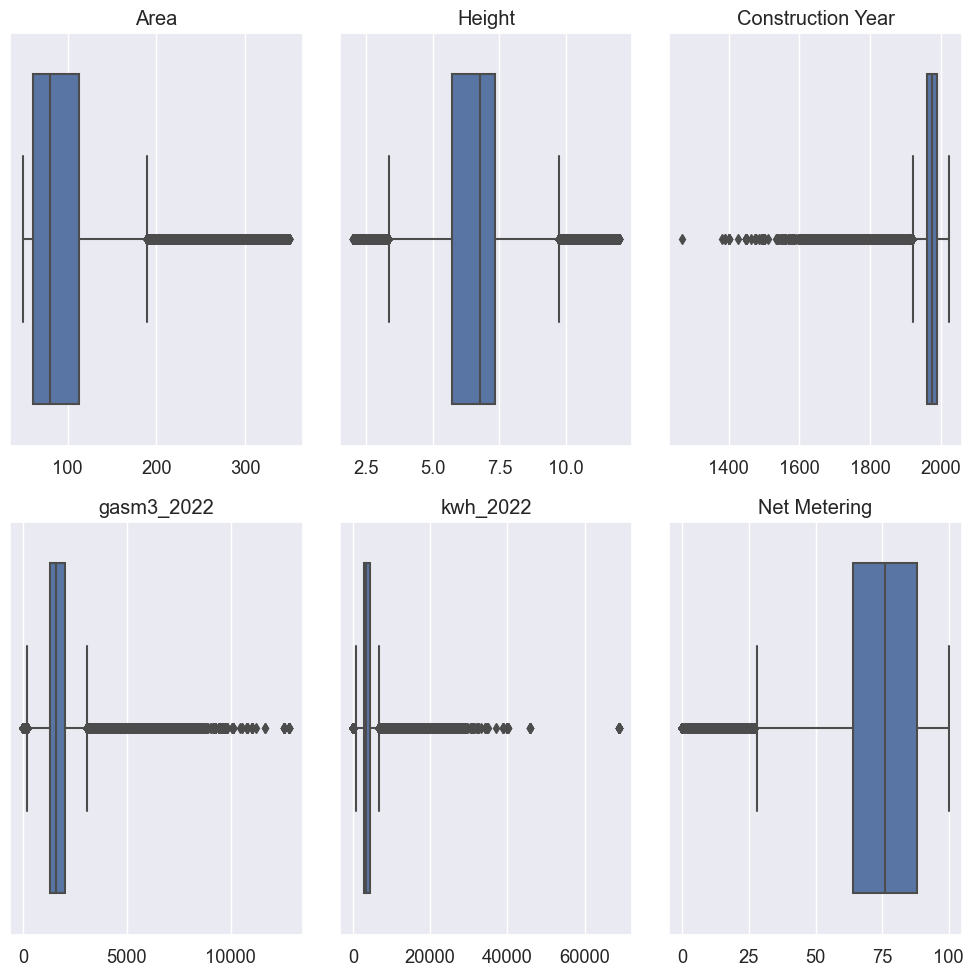

In [28]:
plot_boxplots(df_full, columns =['Area', 'Height', 'Construction Year', 'gasm3_2022', 'kwh_2022', 'Net Metering'])

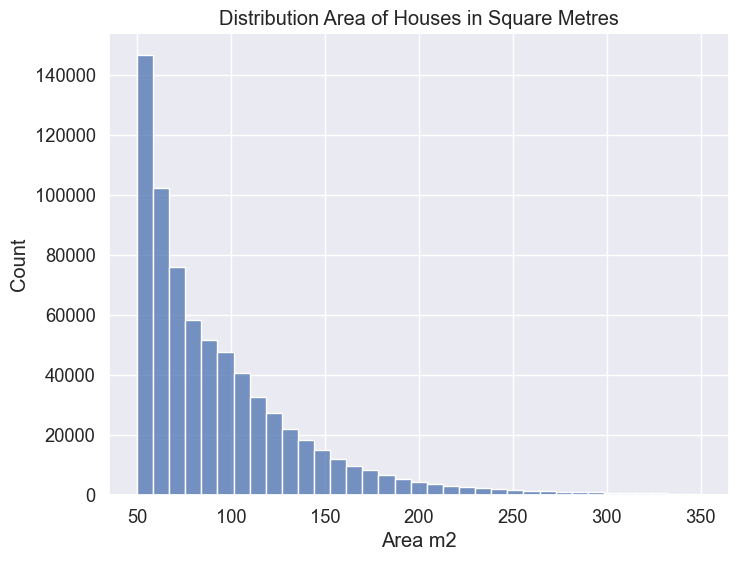

In [29]:
sns.set(style='darkgrid', font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.histplot(df_full['Area'], bins=35)
plt.title('Distribution Area of Houses in Square Metres')
plt.xlabel('Area m2')
plt.ylabel('Count')
plt.show()

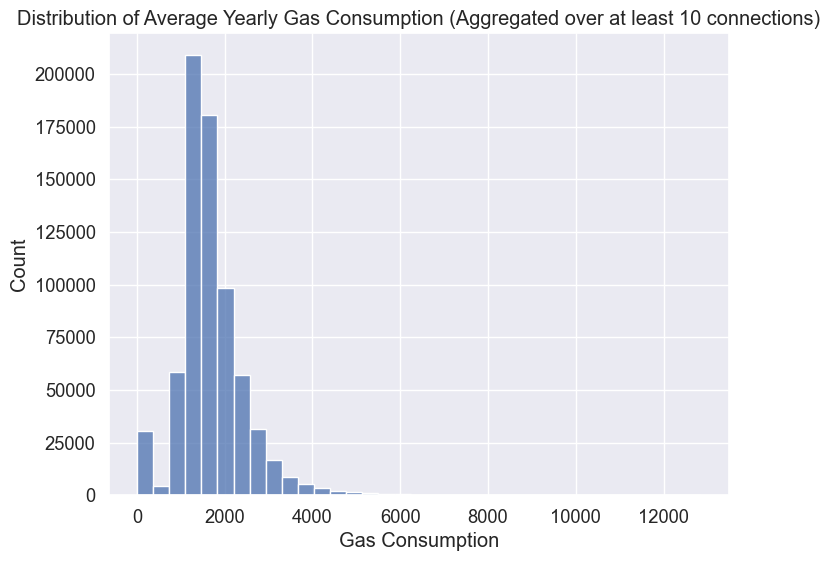

In [30]:
sns.set(style='darkgrid', font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.histplot(df_full['gasm3_2022'], bins=35)
plt.title('Distribution of Average Yearly Gas Consumption (Aggregated over at least 10 connections)')
plt.xlabel('Gas Consumption')
plt.ylabel('Count')
plt.show()

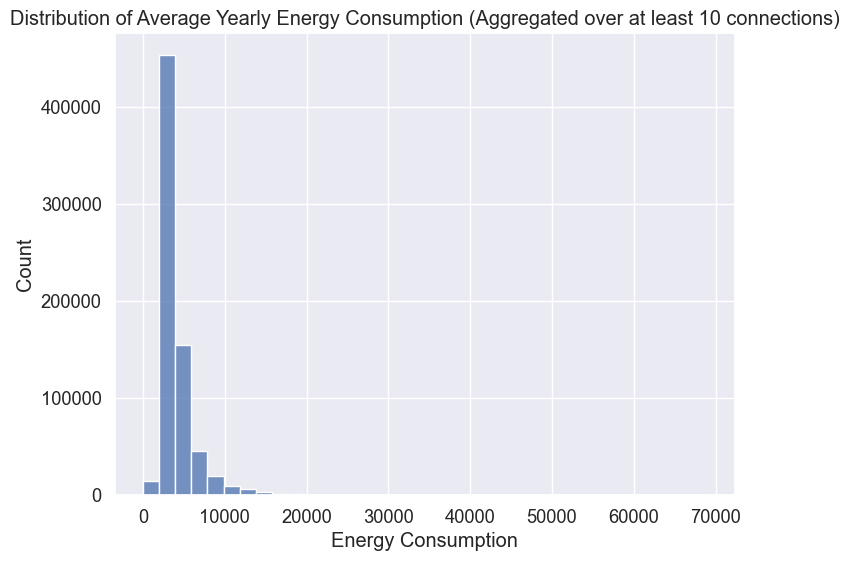

In [31]:
sns.set(style='darkgrid', font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.histplot(df_full['kwh_2022'], bins=35)
plt.title('Distribution of Average Yearly Energy Consumption (Aggregated over at least 10 connections)')
plt.xlabel('Energy Consumption')
plt.ylabel('Count')
plt.show()

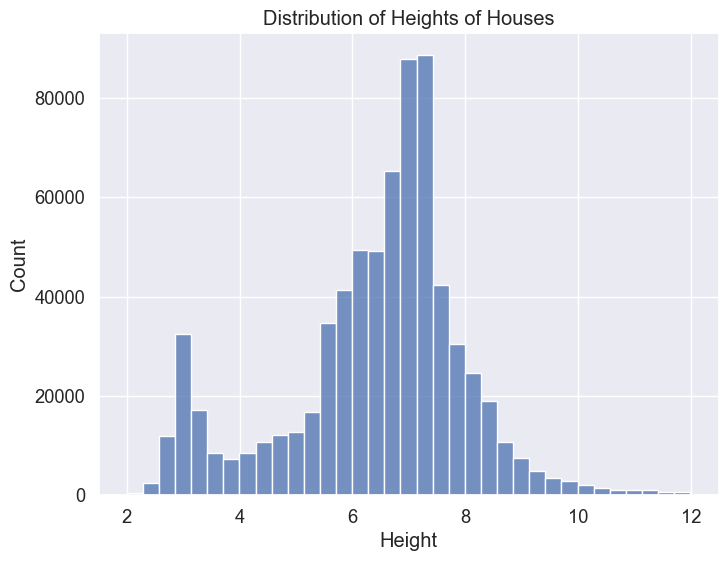

In [32]:
sns.set(style='darkgrid', font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.histplot(df_full['Height'], bins=35)
plt.title('Distribution of Heights of Houses')
plt.xlabel('Height')
plt.ylabel('Count')
plt.show()

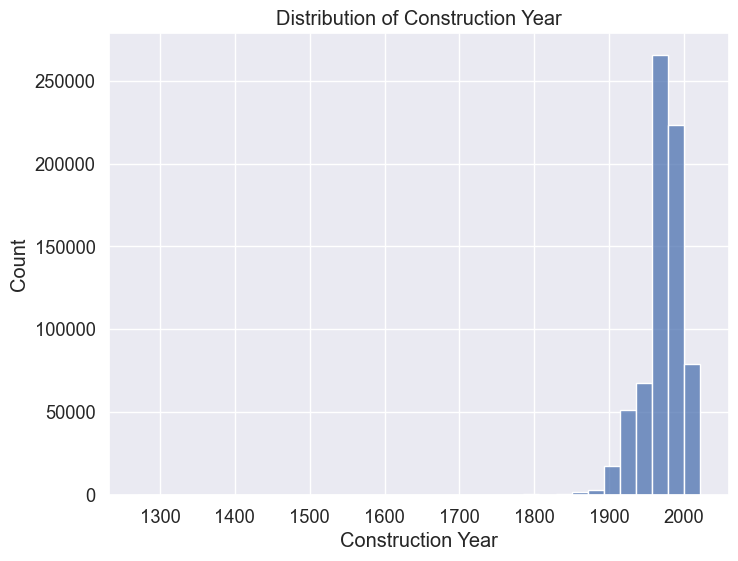

In [33]:
sns.set(style='darkgrid', font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.histplot(df_full['Construction Year'], bins=35)
plt.title('Distribution of Construction Year')
plt.xlabel('Construction Year')
plt.ylabel('Count')
plt.show()

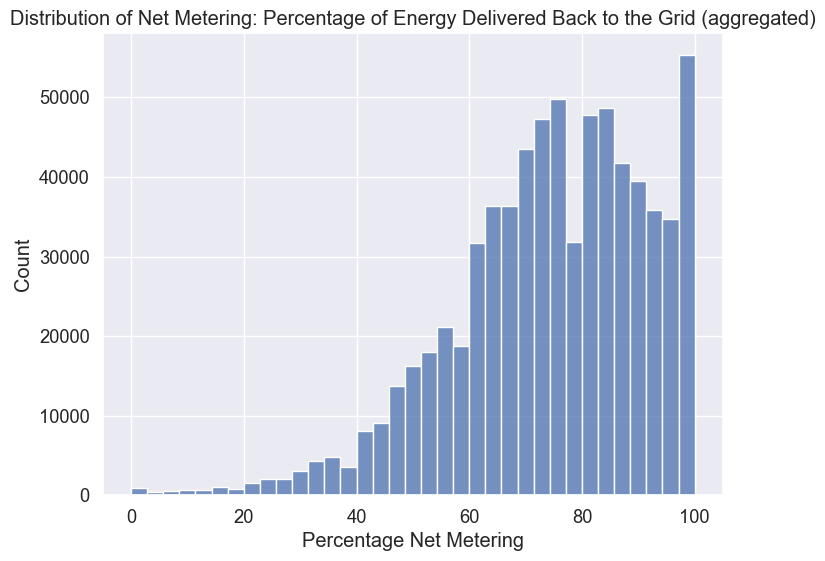

In [34]:
sns.set(style='darkgrid', font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.histplot(df_full['Net Metering'], bins=35)
plt.title('Distribution of Net Metering: Percentage of Energy Delivered Back to the Grid (aggregated)')
plt.xlabel('Percentage Net Metering')
plt.ylabel('Count')
plt.show()

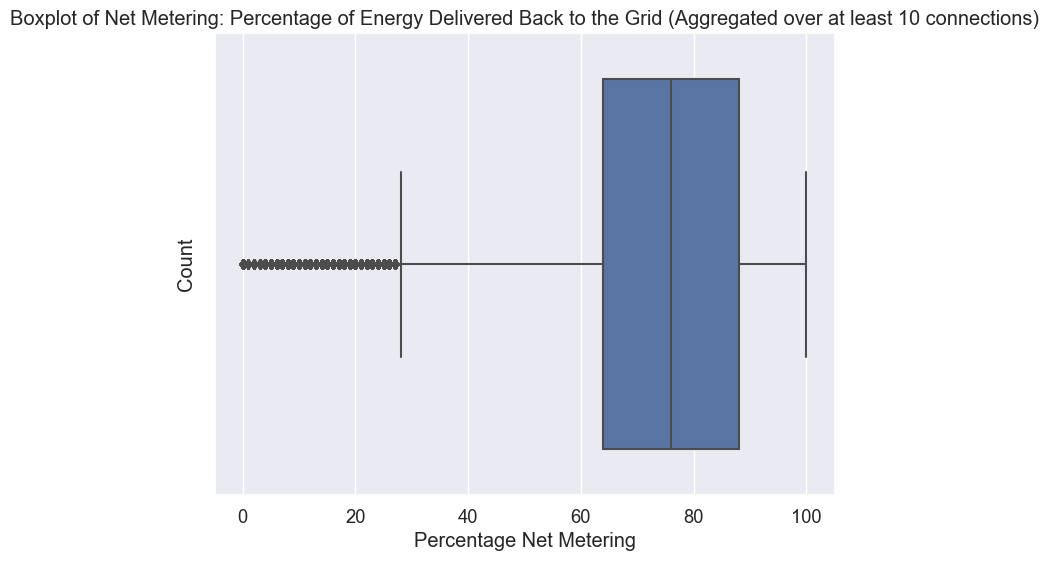

In [35]:
sns.set(style='darkgrid', font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_full['Net Metering'])
plt.title('Boxplot of Net Metering: Percentage of Energy Delivered Back to the Grid (Aggregated over at least 10 connections)')
plt.xlabel('Percentage Net Metering')
plt.ylabel('Count')
plt.show()

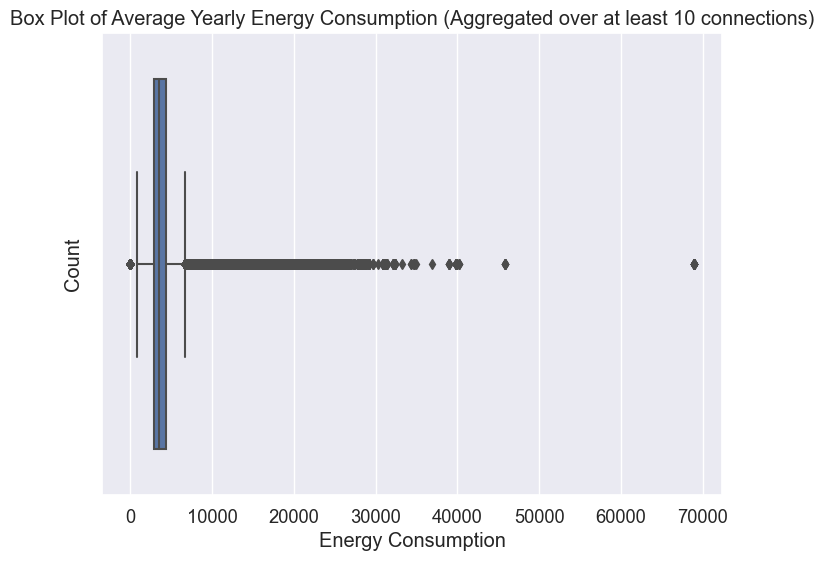

In [36]:
sns.set(style='darkgrid', font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_full['kwh_2022'])
plt.title('Box Plot of Average Yearly Energy Consumption (Aggregated over at least 10 connections)')
plt.xlabel('Energy Consumption')
plt.ylabel('Count')
plt.show()

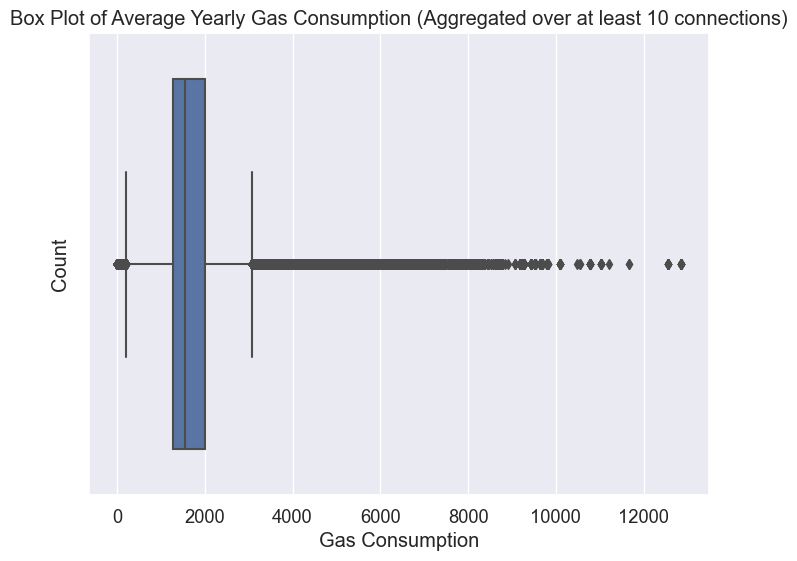

In [37]:
sns.set(style='darkgrid', font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_full['gasm3_2022'])
plt.title('Box Plot of Average Yearly Gas Consumption (Aggregated over at least 10 connections)')
plt.xlabel('Gas Consumption')
plt.ylabel('Count')
plt.show()

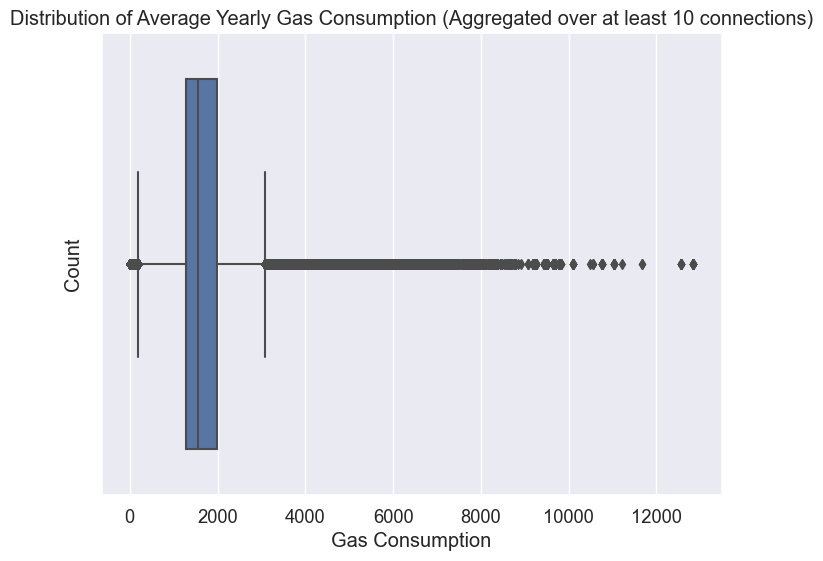

In [38]:
sns.set(style='darkgrid', font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_full['gasm3_2022'])
plt.title('Distribution of Average Yearly Gas Consumption (Aggregated over at least 10 connections)')
plt.xlabel('Gas Consumption')
plt.ylabel('Count')
plt.show()

In [39]:
# Get the 75% quantile values
gas_75_quantile = df_full['gasm3_2022'].quantile(0.75)
kwh_75_quantile = df_full['kwh_2022'].quantile(0.75)

# Make the gas above 75% dataset
df_gas_above_75 = df_full[df_full['gasm3_2022'] > gas_75_quantile]
print(df_gas_above_75.shape)

# Make the energy above 75% dataset
df_kwh_above_75 = df_full[df_full['kwh_2022'] > kwh_75_quantile]
print(df_kwh_above_75.shape)

(177621, 21)
(177800, 21)


In [40]:
df_gas_above_75.describe().round()

,identificatie,Construction Year,Area,Height,gasm3_2022,gas_aansluitingen_2022,pandcount_2022,kwh_aansluitingen_2022,kwh_2022,Net Metering,grondbeslag_m2_p6,volume_m3_p6,gasm3_grondbeslag_p6,gasm3_volume_p6,gasm3_total_p6,Energy Label,woonfunctie_score
count,1.776210e+05,177621.0,177621.0,177621.0,177621.0,177621.0,177621.0,177621.0,177621.0,177621.0,177621.0,177621.0,177621.0,177621.0,177621.0,177621.0,177621.0
mean,1.003491e+15,1962.0,130.0,6.0,2692.0,23.0,29.0,27.0,6405.0,72.0,6201.0,37531.0,16.0,3.0,60660.0,1.0,100.0
std,3.677567e+14,36.0,57.0,2.0,810.0,11.0,26.0,37.0,3382.0,16.0,14829.0,112820.0,7.0,1.0,34408.0,3.0,0.0
min,7.381000e+14,1269.0,50.0,2.0,1998.0,10.0,2.0,0.0,0.0,0.0,133.0,734.0,0.0,0.0,19982.0,-1.0,100.0
25%,7.771000e+14,1947.0,88.0,5.0,2188.0,16.0,19.0,16.0,4236.0,63.0,2285.0,12105.0,12.0,2.0,39775.0,-1.0,100.0
50%,8.401000e+14,1969.0,118.0,6.0,2439.0,21.0,24.0,22.0,5429.0,73.0,3407.0,17836.0,16.0,3.0,52551.0,-1.0,100.0
75%,8.731000e+14,1982.0,158.0,7.0,2889.0,26.0,32.0,29.0,7403.0,83.0,5584.0,30295.0,20.0,4.0,70697.0,4.0,100.0
max,1.959100e+15,2022.0,350.0,12.0,12843.0,193.0,350.0,2273.0,68919.0,100.0,513333.0,5402495.0,532.0,79.0,556278.0,11.0,100.0


In [41]:
df_kwh_above_75.describe().round()

,identificatie,Construction Year,Area,Height,gasm3_2022,gas_aansluitingen_2022,pandcount_2022,kwh_aansluitingen_2022,kwh_2022,Net Metering,grondbeslag_m2_p6,volume_m3_p6,gasm3_grondbeslag_p6,gasm3_volume_p6,gasm3_total_p6,Energy Label,woonfunctie_score
count,1.778000e+05,177800.0,177800.0,177800.0,177800.0,177800.0,177800.0,177800.0,177800.0,177800.0,177800.0,177800.0,177800.0,177800.0,177800.0,177800.0,177800.0
mean,1.009166e+15,1966.0,130.0,6.0,2453.0,24.0,31.0,28.0,6986.0,72.0,6547.0,39551.0,14.0,3.0,58109.0,1.0,100.0
std,3.708755e+14,39.0,58.0,2.0,998.0,15.0,23.0,23.0,3170.0,15.0,16665.0,127239.0,8.0,1.0,37260.0,3.0,0.0
min,7.381000e+14,1388.0,50.0,2.0,0.0,0.0,4.0,10.0,4399.0,4.0,146.0,952.0,0.0,0.0,0.0,-1.0,100.0
25%,7.841000e+14,1950.0,88.0,5.0,1923.0,15.0,19.0,17.0,4952.0,62.0,2414.0,12876.0,10.0,2.0,36083.0,-1.0,100.0
50%,8.401000e+14,1972.0,117.0,6.0,2338.0,21.0,25.0,23.0,5889.0,73.0,3640.0,19415.0,14.0,3.0,50569.0,-1.0,100.0
75%,8.731000e+14,1994.0,157.0,7.0,2843.0,28.0,34.0,31.0,7770.0,83.0,5920.0,32476.0,18.0,3.0,70660.0,5.0,100.0
max,1.959100e+15,2022.0,350.0,12.0,12843.0,367.0,350.0,566.0,68919.0,100.0,513333.0,5402495.0,1318.0,215.0,582820.0,11.0,100.0


In [42]:
# filtering based on ranges of the DEGO, keeping acceptable outliers, deleting extreme outliers
df_filtered = df_full[(df_full['gasm3_2022'] >= 0) & (df_full['gasm3_2022'] <= 4000) & 
                      (df_full['kwh_2022'] >= 0) & (df_full['kwh_2022'] <= 6000)]

print('Shape after filtering: ', df_filtered.shape)

Shape after filtering:  (624530, 21)


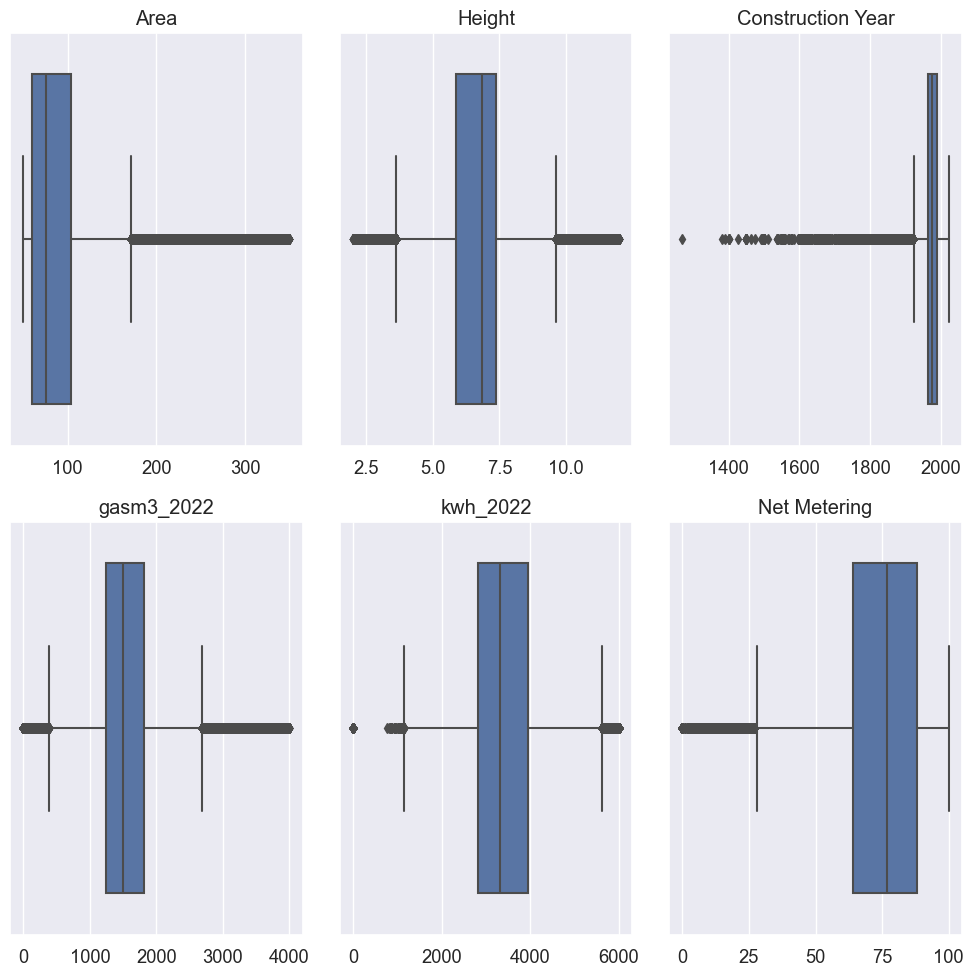

In [43]:
# Checking new boxplots
plot_boxplots(df_filtered, columns =['Area', 'Height', 'Construction Year', 'gasm3_2022', 'kwh_2022', 'Net Metering'])

In [44]:
def plot_distributions(data, colnames):
    sns.set(style='darkgrid', font_scale=1.2)
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
    for i, colname in enumerate(colnames):
        row = i % 3
        col = i // 3
        axs[row, col].hist(data[colname], bins=20)
        axs[row, col].set_xlabel(colname, fontsize=12)
        axs[row, col].set_ylabel('Frequency', fontsize=10)
        axs[row, col].set_title('Distribution of ' + colname, fontsize=14)
        margin = 0.1 * (data[colname].max() - data[colname].min())
        axs[row, col].set_xlim(data[colname].min() - margin, data[colname].max() + margin)
    plt.tight_layout()
    plt.show()

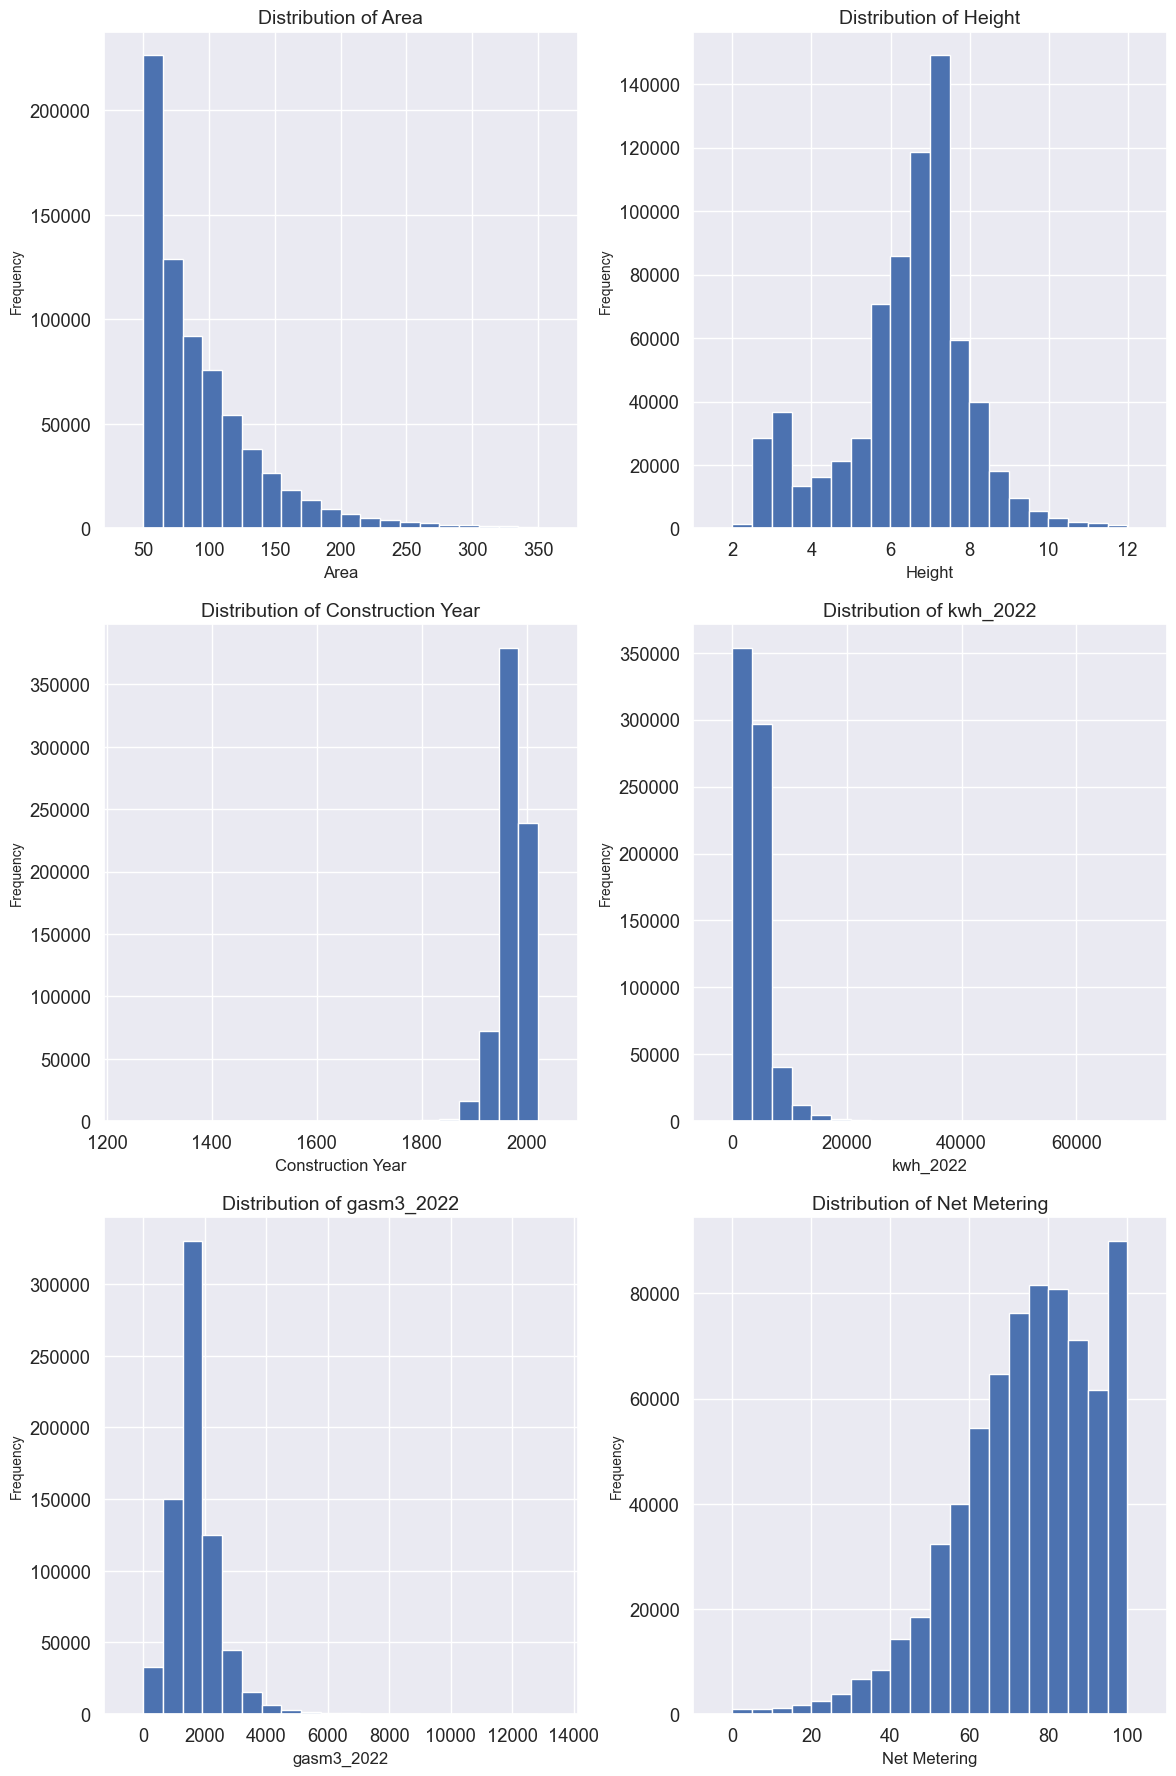

In [45]:
plot_distributions(df_full, ['Area', 'Construction Year', 'gasm3_2022', 
                                 'Height', 'kwh_2022', 'Net Metering'])

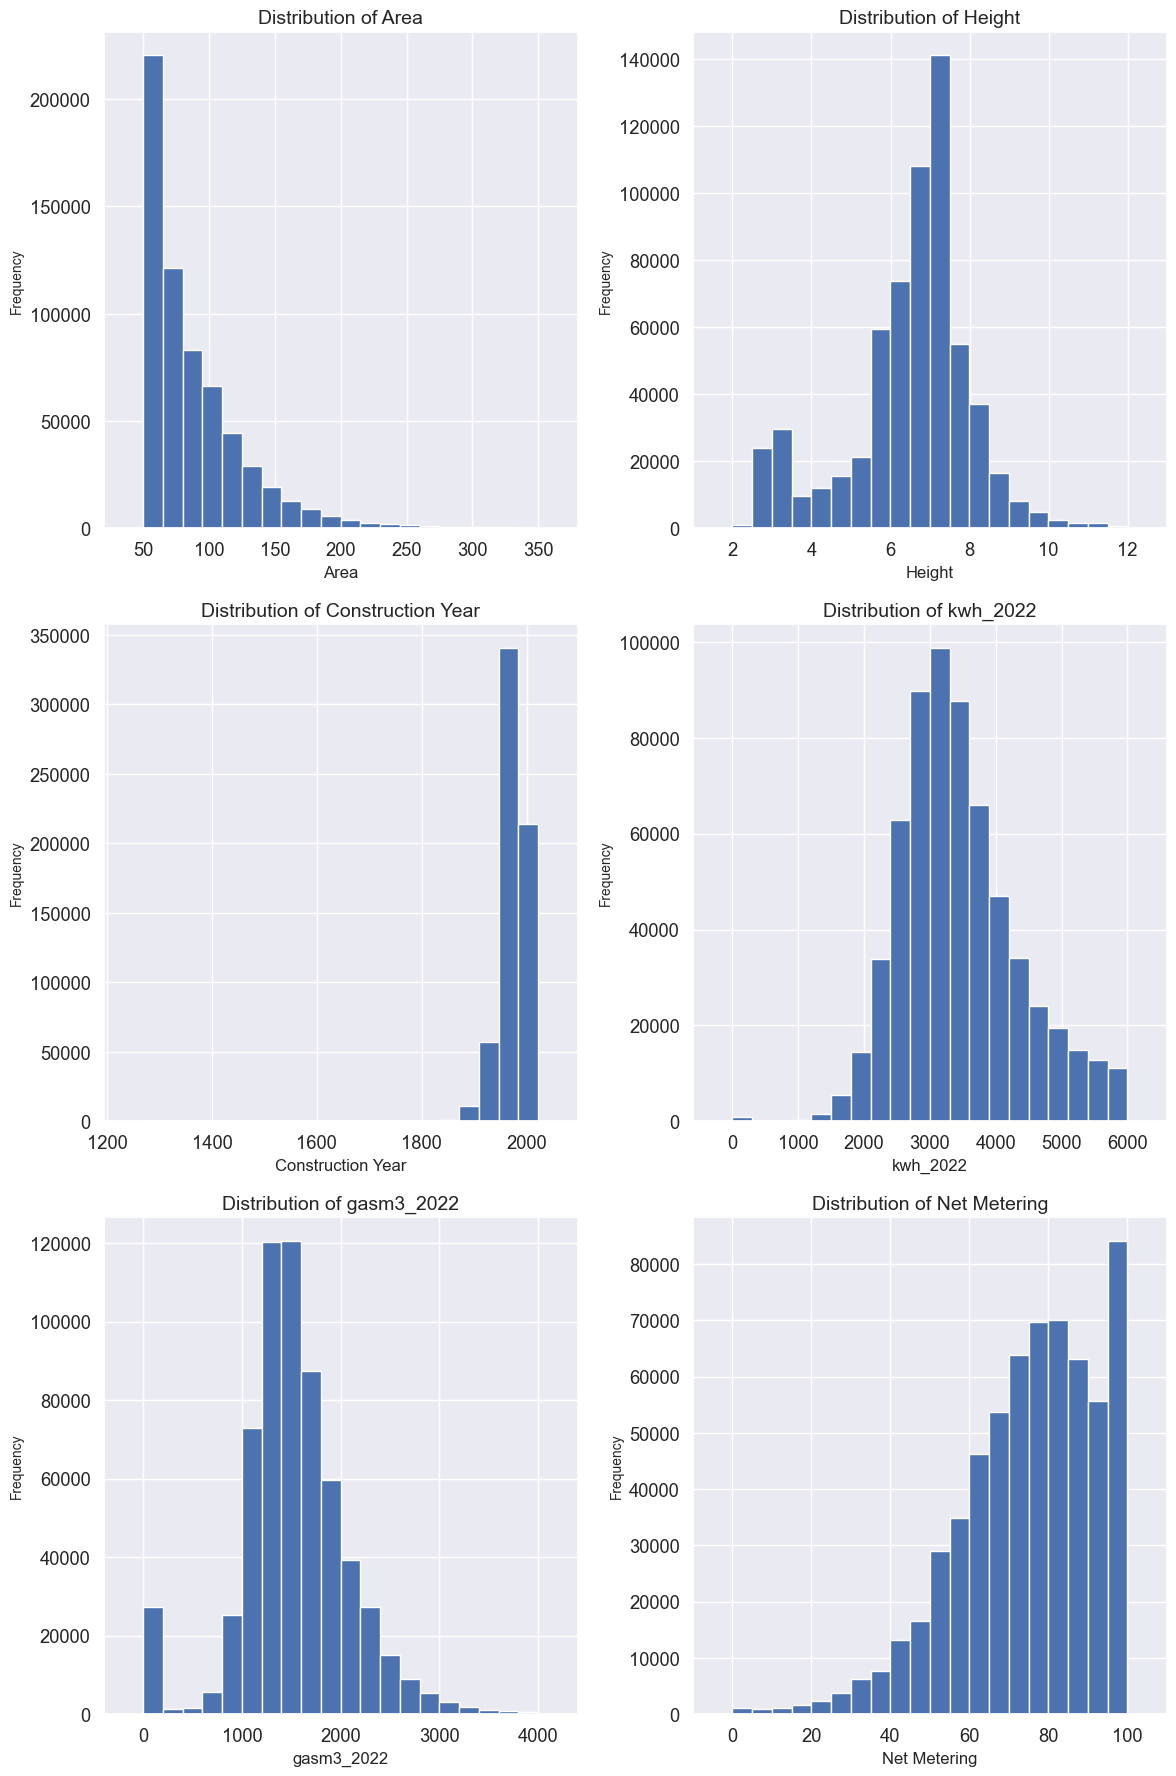

In [46]:
plot_distributions(df_filtered, ['Area', 'Construction Year', 'gasm3_2022', 
                                 'Height', 'kwh_2022', 'Net Metering'])

#### 1.6 Dropping irrelevant variables

In [47]:
# Removing redundant, identification and high-cardinality categorical variables
df_cleaned = df_filtered.drop(['kas_warenhuis', 'identificatie', 'group_id_2022', 'woonfunctie_score'], axis=1)

In [48]:
print('DataFrame shape after irrelevant redundant variables: ',df_cleaned.shape)

DataFrame shape after irrelevant redundant variables:  (624530, 17)


#### 1.7 Feature Creation

##### 1.7.1 Creating Latitude and Longitude

In [49]:
### Merging Latitude and Longitude on Post Code 6 Level with our dataset

# Reading the file with latitude and longitude data (obtained in collaboration with stephan from VNG)
zipcodes_points = pd.read_csv("p6_points_3857_062022.csv")

# Make the zipcode column have the same name as our column 
zipcodes_points.rename(columns = {'postcode':'pc6'}, inplace = True)

# Merge our dataset with the zipcodes dataset
df_merged = pd.merge(df_cleaned, zipcodes_points, on ='pc6', how='left')

In [50]:
# Convert points into valid shapely object
df_merged['point'] = df_merged.point.apply(wkt.loads)

# Convert merged df into a GeoDataFrame
gdf = gpd.GeoDataFrame(df_merged, geometry = 'point', crs = 3857)

# Convert points of post codes to latitude and longitude
df_merged['lon'] = gdf.point.x
df_merged['lat'] = gdf.point.y

In [51]:
df_merged = df_merged.drop(['point'], axis=1)

##### 1.7.2 Creating Volume, Total kWh Consumption

In [52]:
# Creating new building_age feature
df_merged["volume"] = df_merged['Height'] * df_merged["Area"]

In [53]:
# Creating new energy use per building feature based on pand count
df_merged['kwh_totaal_p6'] = df_merged['kwh_2022'] * df_merged['pandcount_2022']

# 2. Splitting Labelled and Unlabelled Data

In [54]:
# Removing the least important features according feature importance scores of random forest
df_merged = df_merged.drop(['kwh_totaal_p6', 'volume_m3_p6', 'grondbeslag_m2_p6', 'gasm3_total_p6'], axis = 1)

In [55]:
# Selecting only -1 labels to make unlabelled dataset
df_unlabelled = df_merged[df_merged['Energy Label'] == -1]

# Exporting to CSV file for convenience
df_unlabelled.to_csv('df_unlabelled.csv', index = False)

In [56]:
# Creating the dataset that is labelled
df_labelled = df_merged[df_merged['Energy Label'] != -1]

# Exporting to CSV file for convenience
df_labelled.to_csv('df_labelled.csv', index = False)

In [57]:
# Loading and checking the unlabelled dataset
unlabelled_df = pd.read_csv('df_unlabelled.csv')
unlabelled_df.shape

(308757, 17)

In [58]:
# Loading and checking the labelled dataset
labelled_df = pd.read_csv('df_labelled.csv')
labelled_df.shape

(315773, 17)

# 3. EDA and Preprocessing on Labelled Dataset

### 3.1 Check for Class Imbalance in Target Variable

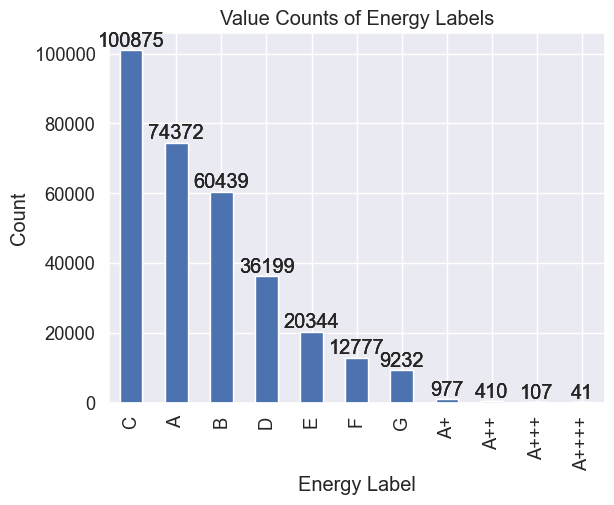

In [59]:
# Prepare for plot, rename categories in the energie_label column
category_dict = {1: 'G', 2: 'F', 3: 'E', 4: 'D', 5: 'C', 6: 'B', 7: 'A', 8:'A+'}
category_counts = labelled_df['Energy Label'].replace(category_dict, inplace = False).value_counts()

# Plot the category_counts
category_counts.plot(kind = 'bar')

# Adding axis labels and titles
plt.xlabel('Energy Label')
plt.ylabel('Count')
plt.title('Value Counts of Energy Labels')


labelled_df['Energy Label'].value_counts().plot(kind='bar')

# Prepare for plot, rename categories in the energie_label column
dictionary = {0: '0', 1: 'G', 2: 'F', 3: 'E', 4: 'D', 5: 'C', 6: 'B', 7: 'A', 8:'A+', 9: 'A++', 10: 'A+++', 11: 'A++++', 12: 'A+++++'}
counts = labelled_df['Energy Label'].replace(dictionary, inplace = False).value_counts()

# Plot the category_counts
ax = counts.plot(kind='bar')

# Adding axis labels and titles
plt.xlabel('Energy Label')
plt.ylabel('Count')
plt.title('Value Counts of Energy Labels')

# Adding value counts above each bar
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=i.datavalues)

### 3.2 Removing infrequent classes & Merging A classes

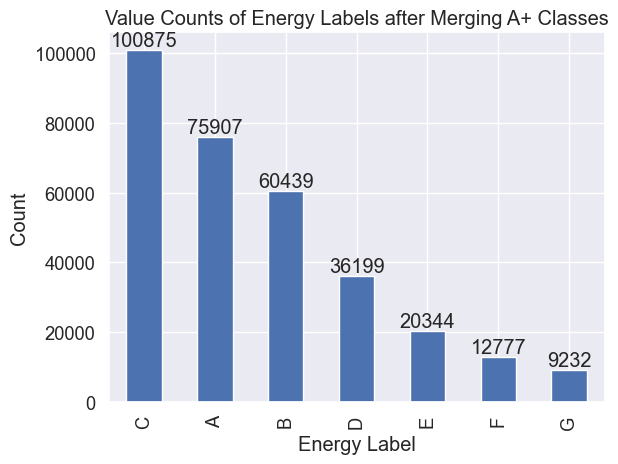

In [60]:
# Removing class 0 and merging A, A+, A++, A+++, A++++, A+++++ into one class (7)

# Removing class 0
labelled_df = labelled_df.drop(labelled_df[labelled_df['Energy Label'] == 0].index)

# Merging classes 
labelled_df['Energy Label'] = labelled_df['Energy Label'].replace([7,8,9,10,11,12], 7)

# Prepare for plot, rename categories in the energie_label column
category_dict = {1: 'G', 2: 'F', 3: 'E', 4: 'D', 5: 'C', 6: 'B', 7: 'A'}
category_counts = labelled_df['Energy Label'].replace(category_dict, inplace = False).value_counts()

# Plot the category_counts
ax = category_counts.plot(kind='bar')

# Adding axis labels and titles
plt.xlabel('Energy Label')
plt.ylabel('Count')
plt.title('Value Counts of Energy Labels after Merging A+ Classes')

# Adding value counts above each bar
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=i.datavalues)

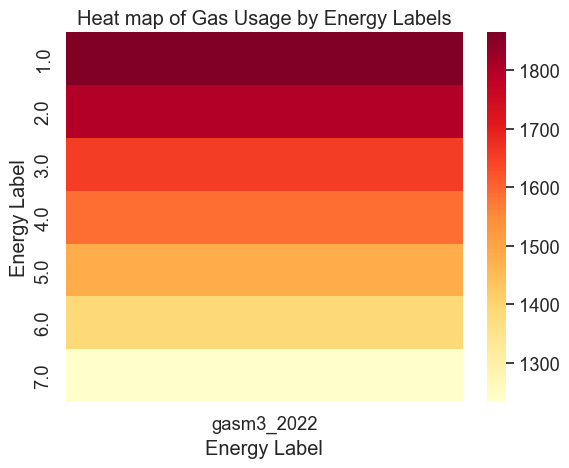

In [61]:
def plot_heatmap_gas(data, x_colname, y_colname):
    sns.set(style='darkgrid', font_scale=1.2)
    heatmap_data = data.pivot_table(values=y_colname, index=x_colname, aggfunc=np.mean)
    sns.heatmap(heatmap_data, cmap='YlOrRd')
    plt.xlabel(x_colname)
    plt.ylabel(x_colname)
    plt.title(f'Heat map of Gas Usage by Energy Labels')
    plt.show()

plot_heatmap_gas(labelled_df, 'Energy Label', 'gasm3_2022')

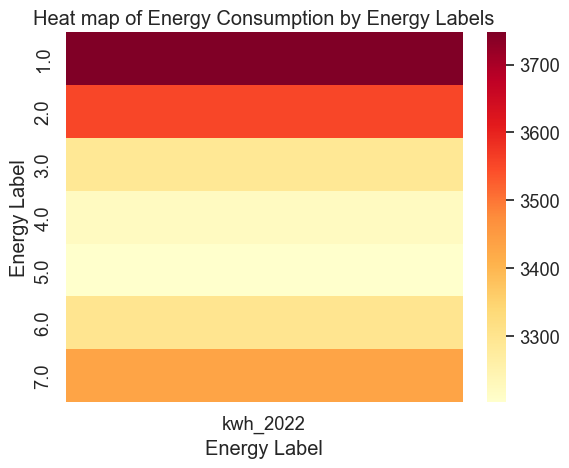

In [62]:
def plot_heatmap_kwh(data, x_colname, y_colname):
    sns.set(style='darkgrid', font_scale=1.2)
    heatmap_data = data.pivot_table(values=y_colname, index=x_colname, aggfunc=np.mean)
    sns.heatmap(heatmap_data, cmap='YlOrRd')
    plt.xlabel(x_colname)
    plt.ylabel(x_colname)
    plt.title(f'Heat map of Energy Consumption by Energy Labels')
    plt.show()

plot_heatmap_kwh(labelled_df, 'Energy Label', 'kwh_2022')

### 3.3 Check Correlation Matrix

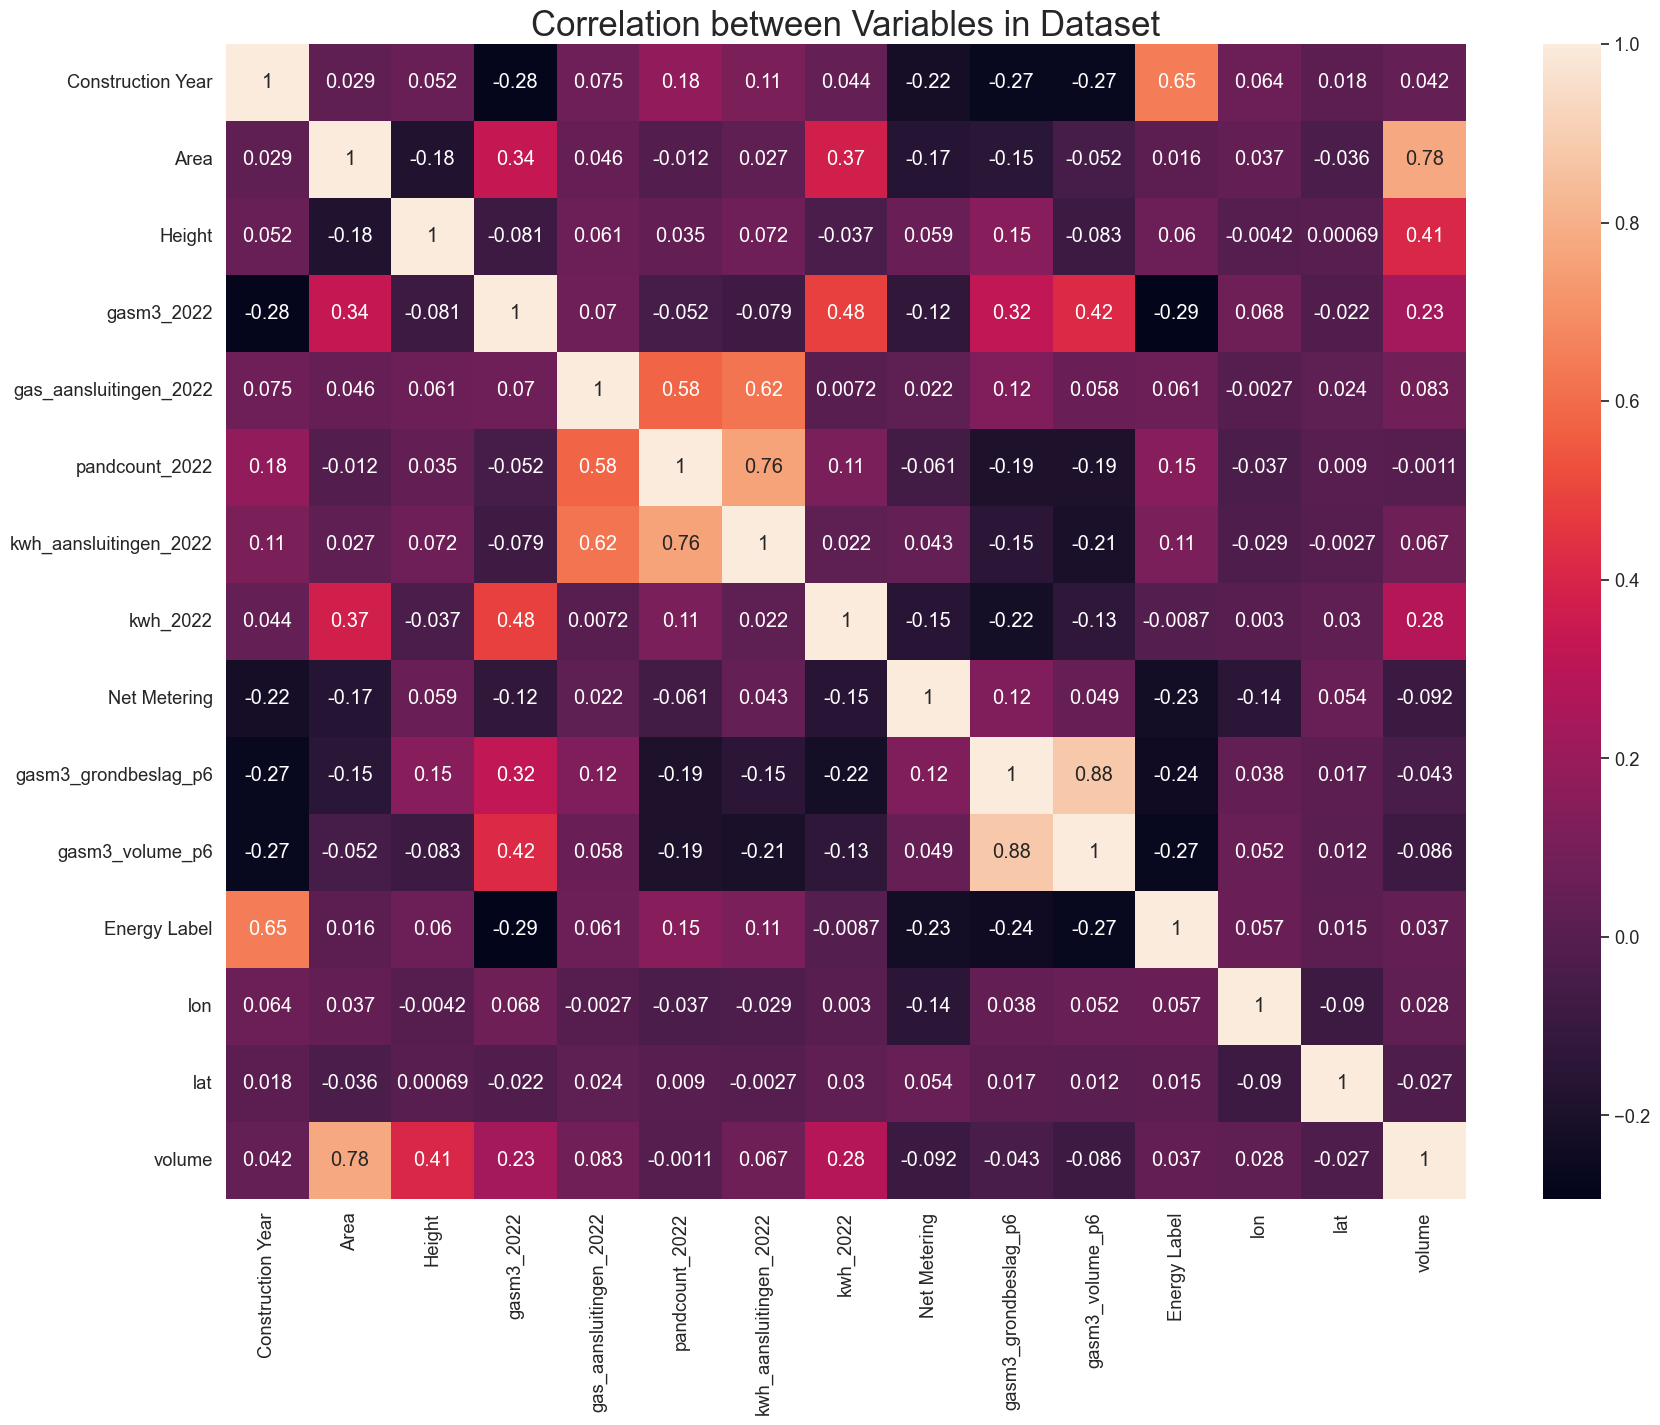

In [63]:
plt.figure(figsize=(20,15))
sns.heatmap(labelled_df.corr(),annot=True, fmt='.2g')
plt.title('Correlation between Variables in Dataset', fontsize=25)
plt.savefig('correlation.png')

### 3.4 Exporting CSV for QGIS

In [64]:
# Save the data for use in QGIS, afterwards drop Geometry and pc6
QGIS_labelled = labelled_df
QGIS_unlabelled = unlabelled_df

# Export to CSV
QGIS_labelled.to_csv("QGIS_labelled.csv")
QGIS_unlabelled.to_csv("QGIS_unlabelled.csv")

# Drop Geometry and pc6
labelled_df = labelled_df.drop(['geometry', 'pc6'], axis=1)

In [65]:
labelled_df.to_csv("labelled_df.csv", index = False)

# 4. Splitting in Train, Validation, and Test set

In [66]:
from sklearn.model_selection import StratifiedShuffleSplit

X_unlabelled = unlabelled_df.drop('Energy Label', axis = 1)
y_unlabelled = unlabelled_df['Energy Label']

X = labelled_df.drop('Energy Label', axis = 1)
y = labelled_df['Energy Label']
# print(f"Shape {y.to_numpy.shape}")

y.value_counts()

5.0    100875
7.0     75907
6.0     60439
4.0     36199
3.0     20344
2.0     12777
1.0      9232
Name: Energy Label, dtype: int64

In [67]:
# Create test split

test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for i, (train_index, test_index) in enumerate (test_split.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, shape {train_index.shape}")
    print(f"  Test:  index={test_index}, shape {test_index.shape}")
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

Fold 0:
  Train: index=[ 15601  53072 241138 ... 124278 290781  88726], shape (252618,)
  Test:  index=[217956  64144 200540 ... 246641 122566 197307], shape (63155,)


#### 4.1 Encoding Target Labels (Energy Labels) + Scaling data

In [68]:
from sklearn import preprocessing

# Labelled dataset: Encode categorical target variable with ordinal encoding
le = preprocessing.LabelEncoder()

# Fit encoder on train set
y_train = le.fit_transform(y_train)

# Use fitted encoder to transform the test set
y_test = le.transform (y_test)

In [69]:
X_train.columns

Index(['Construction Year', 'Area', 'Height', 'gasm3_2022',
       'gas_aansluitingen_2022', 'pandcount_2022', 'kwh_aansluitingen_2022',
       'kwh_2022', 'Net Metering', 'gasm3_grondbeslag_p6', 'gasm3_volume_p6',
       'lon', 'lat', 'volume'],
      dtype='object')

In [70]:
# Drop Geometry and pc6, as these do not need to be entered in the classifiers
X_unlabelled = X_unlabelled.drop(['geometry', 'pc6'], axis=1)

In [71]:
from sklearn.preprocessing import RobustScaler

# Create an instance of the RobustScaler
scaler = RobustScaler()

# Fit the scaler to the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the test set using the scaler fitted on the training set
X_test = scaler.transform(X_test)

# Transform the unlabelled data using the scaler fitted on the training set
X_unlabelled_scaled = scaler.transform(X_unlabelled)

In [72]:
np.savetxt('X_train.txt', X_train, delimiter=',')
np.savetxt('y_train.txt', y_train, delimiter=',')
np.savetxt('X_test.txt', X_test, delimiter=',')
np.savetxt('y_test.txt', y_test, delimiter=',')
np.savetxt('X_unlabelled_scaled.txt', X_unlabelled, delimiter='.')

In [73]:
np.savetxt('y_unlabelled.txt', y_unlabelled, delimiter='.')

# 5. Baseline Models

### 5.1 Baseline Random Forest

In [66]:
# Import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0, n_jobs=-1)

# fit the model
rfc.fit(X_train, y_train)

# Make predictions
y_pred = rfc.predict(X_test)

#### 5.1.1 Evaluation

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score

def evaluate(y_true, y_pred, classifier):
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    cohen_kappa = cohen_kappa_score(y_true, y_pred)

    print("Evaluation metrics for {}:".format(classifier))
    print("Precision macro: {:.4f}".format(precision_macro))
    print("Precision weighted: {:.4f}".format(precision_weighted))
    print("Recall macro: {:.4f}".format(recall_macro))
    print("Recall weighted: {:.4f}".format(recall_weighted))
    print("F1 score macro: {:.4f}".format(f1_macro))
    print("F1 score weighted: {:.4f}".format(f1_weighted))
    print("Balanced accuracy: {:.4f}".format(balanced_accuracy))
    print("Accuracy: {:.4f}".format(accuracy))
    print("Cohen's Kappa Score: {:.4f}".format(cohen_kappa))

In [68]:
evaluate(y_test, y_pred, "Baseline Random Forest")

Evaluation metrics for Baseline Random Forest:
Precision macro: 0.4508
Precision weighted: 0.5625
Recall macro: 0.4355
Recall weighted: 0.5662
F1 score macro: 0.4416
F1 score weighted: 0.5619
Balanced accuracy: 0.4355
Accuracy: 0.5662
Cohen's Kappa Score: 0.4395


In [79]:
# Code adapted from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
def plot_confusion_matrix(y_true, y_pred, model_name):
    # Class names
    class_names = ['G', 'F', 'E', 'D', 'C', 'B', 'A']

    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_true, y_pred)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':13},
                cmap=plt.cm.Greens, linewidths=0.2,
                vmin=0, vmax=1)  # set fixed scale between 0-1

    # Add labels to the plot
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix for ' + model_name)
    plt.show()


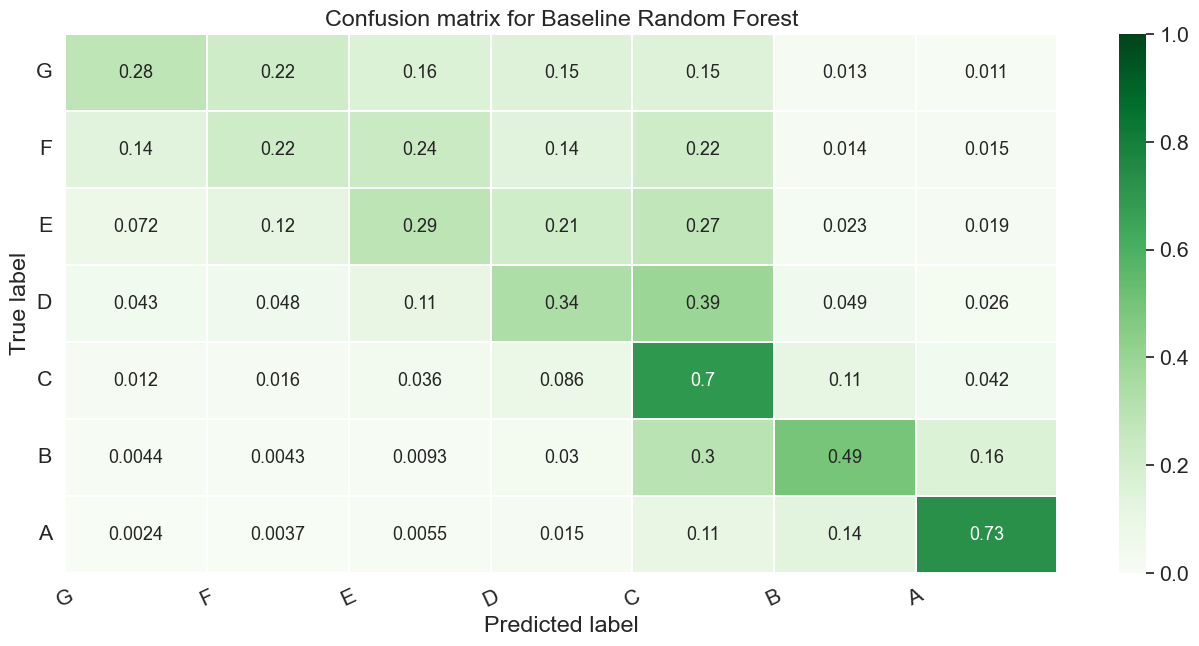

In [72]:
plot_confusion_matrix(y_test, y_pred, "Baseline Random Forest")

In [73]:
# Make a list of class names to make classification report more readable
class_names = ['G', 'F', 'E', 'D', 'C', 'B', 'A']

# Print classification report
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

           G       0.29      0.28      0.29      1846
           F       0.26      0.22      0.24      2555
           E       0.31      0.29      0.30      4069
           D       0.39      0.34      0.36      7240
           C       0.58      0.70      0.63     20175
           B       0.55      0.49      0.52     12088
           A       0.78      0.73      0.75     15182

    accuracy                           0.57     63155
   macro avg       0.45      0.44      0.44     63155
weighted avg       0.56      0.57      0.56     63155



### 5.2 Baseline XGboost

In [74]:
import xgboost as xgb

# Initiate classifier
xgb_clf = xgb.XGBClassifier(random_state=0, n_jobs=-1, tree_method='gpu_hist')

# Fit the model
xgb_clf.fit(X_train, y_train, verbose=False)

# Make predictions
y_pred_xgb = xgb_clf.predict(X_test)

#### 5.2.1 Evaluation 

In [75]:
evaluate(y_test, y_pred_xgb, "Baseline XGBoost")

Evaluation metrics for Baseline XGBoost:
Precision macro: 0.4832
Precision weighted: 0.5866
Recall macro: 0.4398
Recall weighted: 0.5764
F1 score macro: 0.4474
F1 score weighted: 0.5625
Balanced accuracy: 0.4398
Accuracy: 0.5764
Cohen's Kappa Score: 0.4423


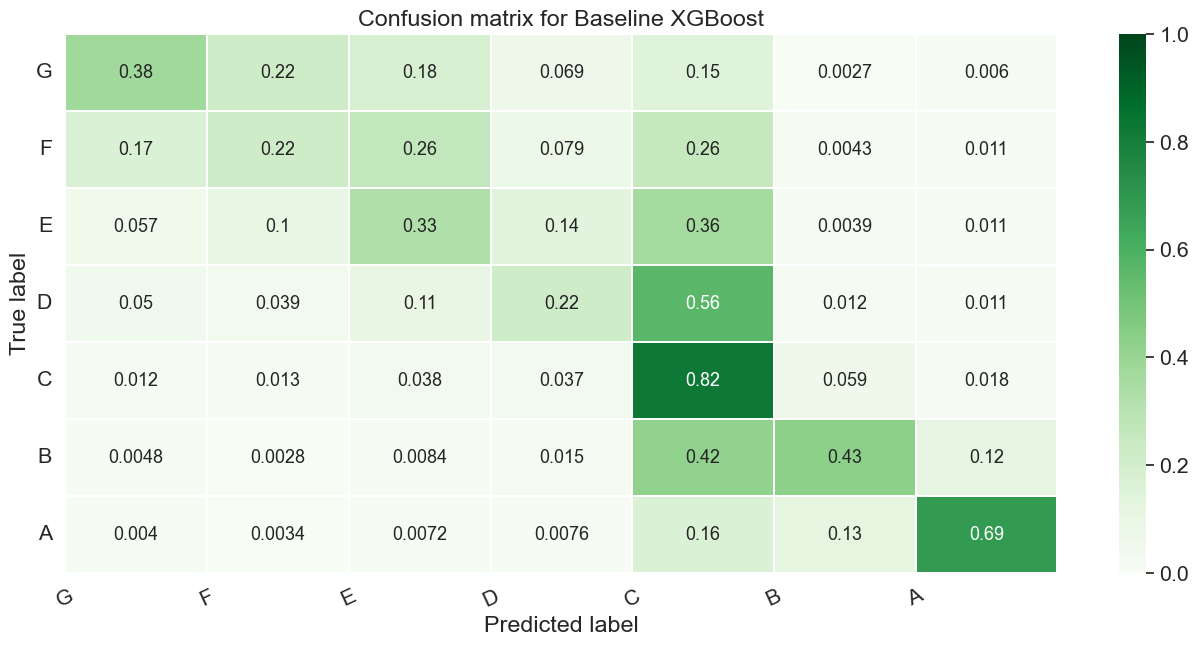

In [76]:
plot_confusion_matrix(y_test, y_pred_xgb, "Baseline XGBoost")

In [77]:
# Print classification report
print(classification_report(y_test, y_pred_xgb, target_names = class_names))

              precision    recall  f1-score   support

           G       0.33      0.38      0.35      1846
           F       0.27      0.22      0.24      2555
           E       0.32      0.33      0.33      4069
           D       0.45      0.22      0.29      7240
           C       0.54      0.82      0.65     20175
           B       0.62      0.43      0.51     12088
           A       0.84      0.69      0.76     15182

    accuracy                           0.58     63155
   macro avg       0.48      0.44      0.45     63155
weighted avg       0.59      0.58      0.56     63155



### 5.3 Baseline TabNet

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
print(device)

cuda


In [76]:
from pytorch_tabnet.tab_model import TabNetClassifier

# Initiate the classifier
clf_tabnet = TabNetClassifier(device_name = device)

# Fit the classifier 
clf_tabnet.fit(X_train, y_train)
               
# Predict the validation/test set results
y_prob_tabnet = clf_tabnet.predict_proba(X_test)
y_pred_tabnet = np.argmax(y_prob_tabnet, axis=1)

epoch 0  | loss: 1.31033 |  0:00:09s
epoch 1  | loss: 1.23306 |  0:00:17s
epoch 2  | loss: 1.22998 |  0:00:26s
epoch 3  | loss: 1.22617 |  0:00:34s
epoch 4  | loss: 1.22361 |  0:00:42s
epoch 5  | loss: 1.2188  |  0:00:51s
epoch 6  | loss: 1.21584 |  0:00:59s
epoch 7  | loss: 1.21514 |  0:01:07s
epoch 8  | loss: 1.21212 |  0:01:15s
epoch 9  | loss: 1.21073 |  0:01:24s
epoch 10 | loss: 1.2114  |  0:01:32s
epoch 11 | loss: 1.21129 |  0:01:41s
epoch 12 | loss: 1.20534 |  0:01:50s
epoch 13 | loss: 1.20347 |  0:01:59s
epoch 14 | loss: 1.20171 |  0:02:08s
epoch 15 | loss: 1.19884 |  0:02:17s
epoch 16 | loss: 1.19736 |  0:02:26s
epoch 17 | loss: 1.19626 |  0:02:34s
epoch 18 | loss: 1.19595 |  0:02:43s
epoch 19 | loss: 1.19455 |  0:02:51s
epoch 20 | loss: 1.19355 |  0:03:00s
epoch 21 | loss: 1.19214 |  0:03:07s
epoch 22 | loss: 1.19065 |  0:03:16s
epoch 23 | loss: 1.1908  |  0:03:24s
epoch 24 | loss: 1.18918 |  0:03:33s
epoch 25 | loss: 1.18853 |  0:03:41s
epoch 26 | loss: 1.18806 |  0:03:49s
e

#### 5.3.1 Evaluation

In [80]:
evaluate(y_test, y_pred_tabnet, "Baseline TabNet")

Evaluation metrics for Baseline TabNet:
Precision macro: 0.4429
Precision weighted: 0.5360
Recall macro: 0.3746
Recall weighted: 0.5279
F1 score macro: 0.3758
F1 score weighted: 0.4904
Balanced accuracy: 0.3746
Accuracy: 0.5279
Cohen's Kappa Score: 0.3637


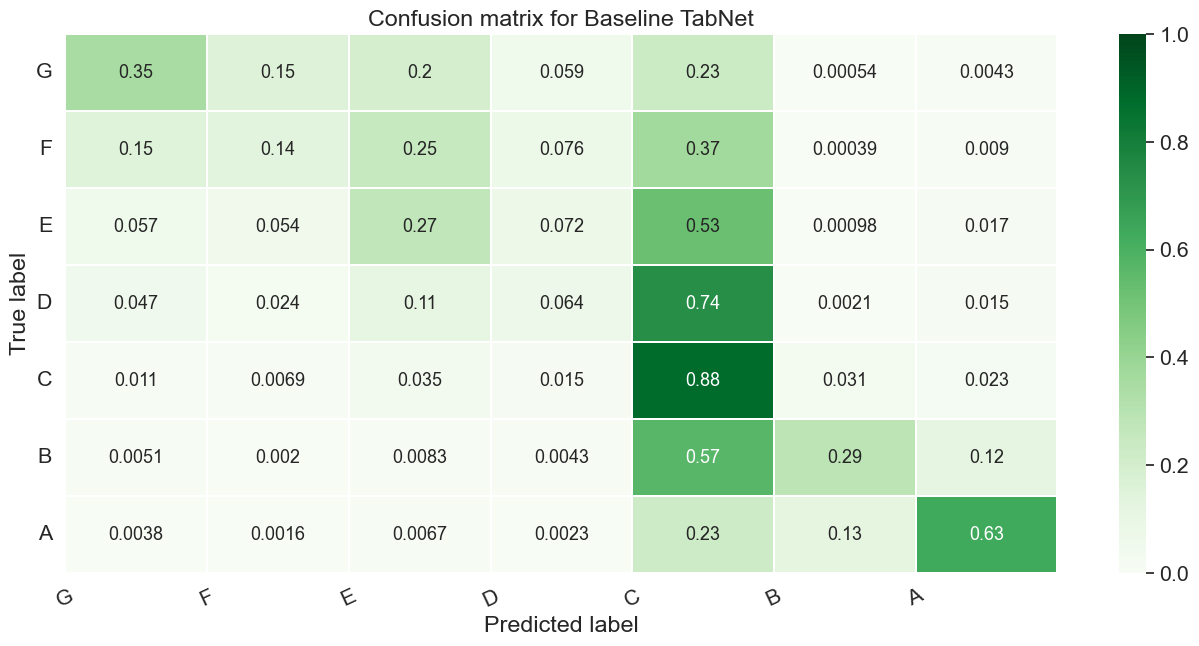

In [81]:
plot_confusion_matrix(y_test, y_pred_tabnet, "Baseline TabNet")

In [83]:
# Make a list of class names to make classification report more readable
class_names = ['G', 'F', 'E', 'D', 'C', 'B', 'A']

# Printing classification report
print(classification_report(y_test, y_pred_tabnet, target_names = class_names))

              precision    recall  f1-score   support

           G       0.33      0.35      0.34      1846
           F       0.29      0.14      0.19      2555
           E       0.29      0.27      0.28      4069
           D       0.32      0.06      0.11      7240
           C       0.48      0.88      0.62     20175
           B       0.58      0.29      0.38     12088
           A       0.82      0.63      0.71     15182

    accuracy                           0.53     63155
   macro avg       0.44      0.37      0.38     63155
weighted avg       0.54      0.53      0.49     63155



In [ ]:
np.save('X_unlabelled_scaled.npy', X_unlabelled_scaled)

In [90]:
X_unlabelled_scaled.shape

(308757, 14)

In [91]:
X_un_scaled= np.load('X_unlabelled_scaled.npy')

In [92]:
X_un_scaled.shape

(308757, 14)